# **1 Author**

**Student Name**:  Syed Farhan Haider

**Student ID**:  230797682


# **2 Problem formulation**

Utilizing the MLEnd Yummy Dataset, develop a machine learning pipeline designed to take a photo of a dish containing either rice or chips as input, and predict whether the image features indicate the presence of rice or chips. The interesting thing about this task is to identify the image features that significantly impact the prediction of whether the image depicts a dish with rice or chips.

# **3 Machine Learning pipeline**


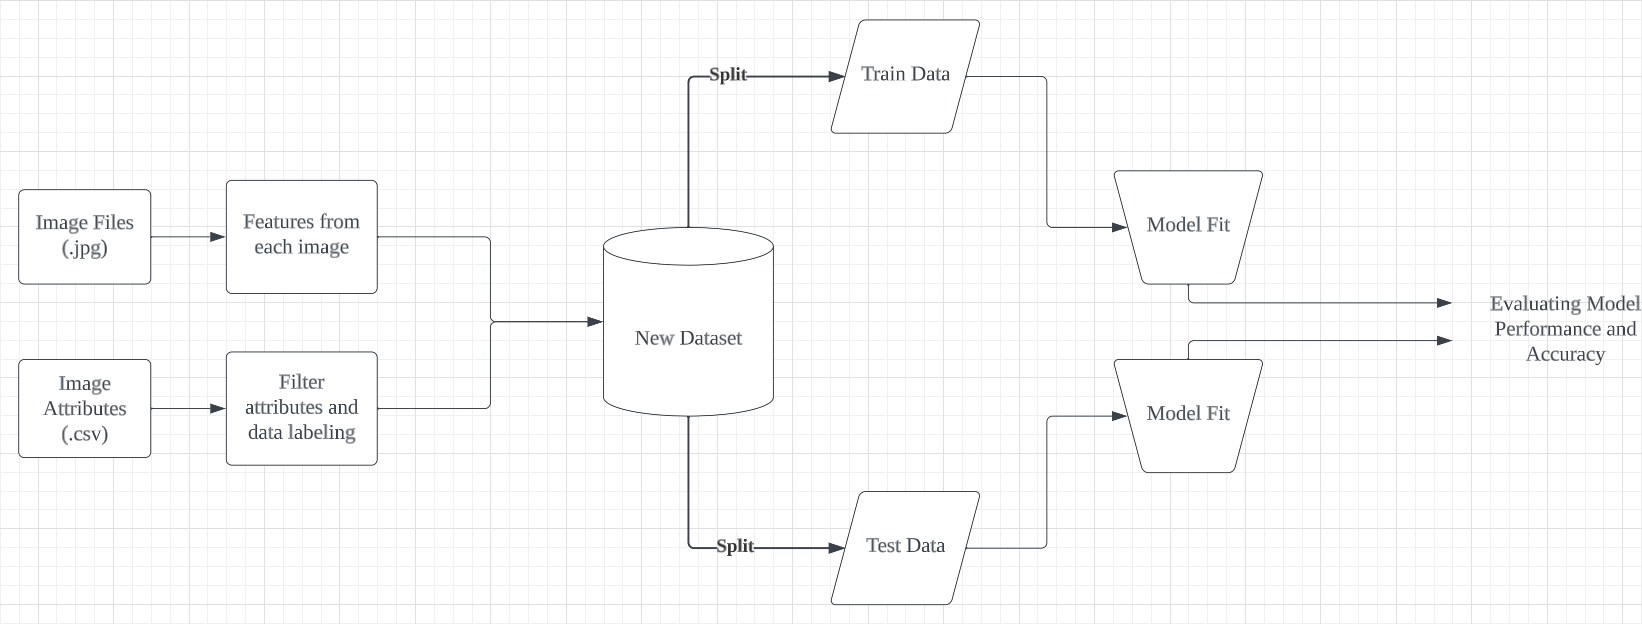

The machine learning pipeline involves the following stages:

**a. Data Download and Preprocessing:** Downloading the MLEnd Yummy Dataset, filtering the data to include only images containing rice or chips, handling class imbalance, and splitting the dataset into training and testing sets.

**b. Image Processing:** Resizing and standardizing the images to create the input for the machine learning models.

**c. Feature Extraction:** Extracting features from the images, including the yellow component, color histograms, and GMLC features.

**d. Model Training:** Training machine learning models (Linear SVM and Logistic Regression) using the extracted features.

**e. Evaluation:** Evaluating the models on both the training and testing sets to assess their accuracy.

# **4 Transformation stage**

###**a. Data Download and Preprocessing:**

In [1]:
!pip install mlend

  Using cached mlend-1.0.0.3-py3-none-any.whl (10 kB)
  Using cached spkit-0.0.9.6.7-py3-none-any.whl (1.6 MB)
  Using cached python_picard-0.7-py3-none-any.whl (16 kB)
  Using cached pylfsr-1.0.7-py3-none-any.whl (28 kB)
  Using cached phyaat-0.0.3-py3-none-any.whl (27 kB)


In [2]:
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing the necessary libraries
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy, yummy_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


Downloading the labeled data from the drive. This dataset contains the images that contain either rice or chips.

In [4]:
baseDir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd')
baseDir

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


'/content/drive/MyDrive/Data/MLEnd/yummy'

Now let's check the contents of the folder

In [5]:
os.listdir(baseDir)

['MLEndYD_images_small',
 'MLEndYD_images',
 'MLEndYD_image_attributes_small.csv',
 'MLEndYD_image_attributes_benchmark.csv']

For this project we will use the larger dataset.
Let's create a dataframe using the benchmark csv and take a look at the contents.

In [6]:
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


As our focus is to take images with only rice and chips, let's filter the data using dishname and ingredients.

In [7]:
import pandas as pd

# Filtering rows containing rice or chips in Dish_name or Ingredients. Notice that chocochips is being ignored
filtered_df = MLENDYD_df[MLENDYD_df['Dish_name'].str.contains('(rice|chips|fries|wedges)', case=False, na=False) | MLENDYD_df['Ingredients'].str.contains('(rice|chips)', case=False, na=False)]

Let's display the data and see whether the required action is fulfilled.

In [8]:
filtered_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003234.jpg,vegetarian,indian,indian,rasam_rice,home,"garlic,curry_leaves,green_chilli,cumin,black_p...",very_healthy,5.0,strongly_like,5.0,Test
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train


This is the desired dataset that we have to use for our model. Notice that we don't have any rows labeled as rice or chips

A total of 638 dishes found that include either rice or chips

Lets check first and last image from our new dataset and get some insights.

(-0.5, 1151.5, 863.5, -0.5)

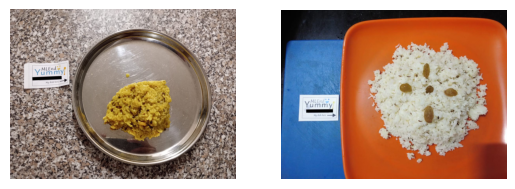

In [9]:
I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/000016.jpg')
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off')

I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/003246.jpg')
plt.subplot(1,2,2)
plt.imshow(I)
plt.axis('off')

As expected, the images contain either rice or chips. Looks delicious though!

Let's create a label column for this dataset

In [10]:
filtered_df['Rice'] = (filtered_df['Dish_name'].str.contains('rice', case=False, na=False) | filtered_df['Ingredients'].str.contains('rice', case=False, na=False)).astype(int)

Let's see if the Label is added.

In [11]:
filtered_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,1
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,1
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,1
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,1
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...
003234.jpg,vegetarian,indian,indian,rasam_rice,home,"garlic,curry_leaves,green_chilli,cumin,black_p...",very_healthy,5.0,strongly_like,5.0,Test,1
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,1
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,1


There is a high possibility that there might be some dishes that include chocolate chips. Let's filter the dataset again and remove the chocolate chips.

In [12]:
filtered_df = filtered_df[filtered_df['Ingredients'].str.contains('chocolate')==False].copy()

Let's count the no. of rice dataset and no. of chips dataset to identify if there is an imbalance.

In [13]:
filtered_df[filtered_df['Rice']==0]

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice
filename,,,,,,,,,,,,
000024.jpg,vegan,british,british,pie_and_chips,home,"mushroom_pie,chips,peas",neutral,3.0,like,4.0,Train,0
000096.jpg,non_vegetarian,english,english,"fish_burger,chips,onion_rings",home,"cod_fillets,panko_bread_crumbs,onions,potatoes...",unhealthy,2.0,like,4.0,Train,0
000107.jpg,vegetarian,english,english,sandwich_with_potatos_fries,home,"bread,potato,tomato,onion,spices,potato_fries",unhealthy,2.0,strongly_like,5.0,Test,0
000140.jpg,vegan,american,american,potato_wedges,restaurant,"potatoes,olive_oil,salt",unhealthy,2.0,like,4.0,Train,0
000160.jpg,non_vegetarian,english,english,grilled_chicken_wings_and_chips,restaurant,"1/2_chicken,olive_oil,salt,pepper,herbs/spices...",healthy,4.0,dislike,2.0,Train,0
...,...,...,...,...,...,...,...,...,...,...,...,...
003034.jpg,non_vegetarian,american,american,chicken_burger_with_fries,restaurant,"chicken,bread,lettuce,tomato,mayonise,cheese,s...",unhealthy,2.0,neutral,3.0,Train,0
003174.jpg,non_vegetarian,american,american,nuggets_and_chips,mcdonalds,"chicken,potatoes,salt,mayonnaise,ketchup",very_unhealthy,1.0,like,4.0,Train,0
003181.jpg,non_vegetarian,american,american,beef_burger_and_chips,flames,"burgen_bun,onion,cheese,ketchup,lettuce,tomato...",neutral,3.0,strongly_like,5.0,Train,0


In [14]:
filtered_df[filtered_df['Rice']==1]

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,1
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,1
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,1
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,1
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...
003234.jpg,vegetarian,indian,indian,rasam_rice,home,"garlic,curry_leaves,green_chilli,cumin,black_p...",very_healthy,5.0,strongly_like,5.0,Test,1
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,1
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,1


As we can observe, the rice dataset is huge when compared to chips. There are 802 samples of rice dishes and only 122 samples of chips dishes. Let's handle this imbalance by using over sampling technique.

Let's first split data into TrainSet and TestSet using the Benchmark_A column.

In [15]:
# Creating a mask using Benchmark_A column

mask_train = filtered_df['Benchmark_A'] == 'Train'

We will now split the dataset based on the mask. Note that we will ignore every column but the filename and label as only these are required for our solution.

In [16]:
# Splitting the data based on the mask.

TrainSet = pd.DataFrame(filtered_df[mask_train]['Rice'])
TestSet = pd.DataFrame(filtered_df[~mask_train]['Rice'])

In [17]:
print("TrainSet before over sampling")
print("Rice Samples = ",len(TrainSet[TrainSet['Rice']==1]))
print("Chips Samples = ",len(TrainSet[TrainSet['Rice']==0]))

TrainSet before over sampling
Rice Samples =  553
Chips Samples =  83


In [18]:
import pandas as pd
from sklearn.utils import resample

rice_dishes = TrainSet[TrainSet['Rice']==1]
chips_dishes = TrainSet[TrainSet['Rice']==0]

# Under-sampling rice dishes to match the number of chips dishes
over_sampled_chips = resample(chips_dishes, replace=True, n_samples=553, random_state=42)

# Concatenating the under-sampled rice dishes with the original chips dishes
TrainSet = pd.concat([rice_dishes, over_sampled_chips])

Let's see if we have the desired output.

In [19]:
print("TrainSet after over sampling")
print("Rice Samples = ",len(TrainSet[TrainSet['Rice']==1]))
print("Chips Samples = ",len(TrainSet[TrainSet['Rice']==0]))

TrainSet after over sampling
Rice Samples =  553
Chips Samples =  553


Great! We now have equal no. of rice and chips samples.

Let's add X_paths that will contain the path of each corresponding image in the dataset. This way our model can access the images.

In [20]:
TrainSet['X_paths'] = "/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/"+TrainSet.index
TestSet['X_paths'] = "/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/"+TestSet.index

In [21]:
TrainSet.shape

(1106, 2)

In [22]:
TestSet.shape

(288, 2)

Our dataset is now ready to be used. Let's save the predictors and labels of the training and test dataset:

In [23]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Rice']
Y_test  = TestSet['Rice']

Let's visualise the images that we have extracted.

Rice


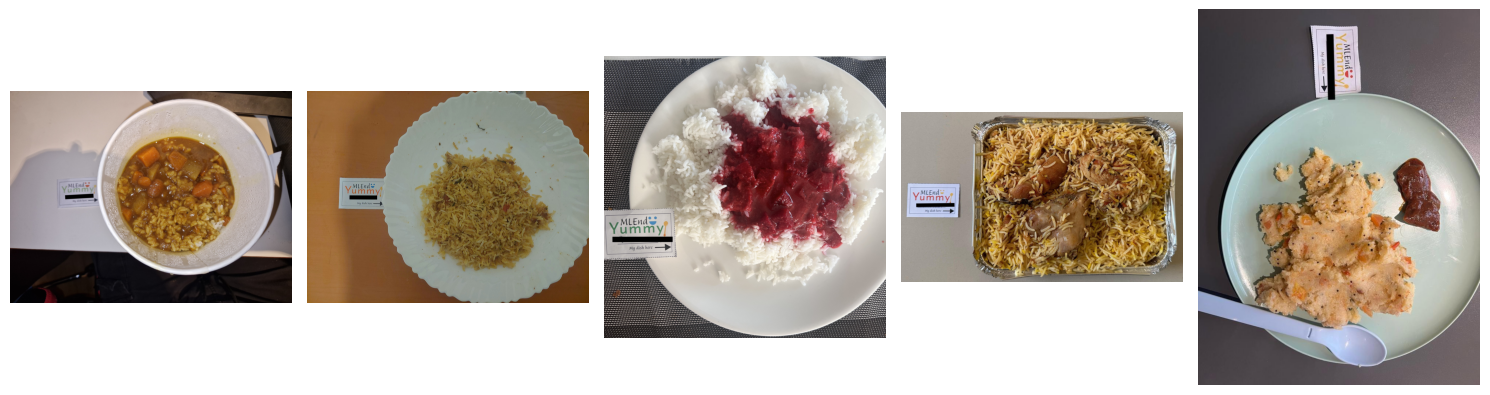

Chips


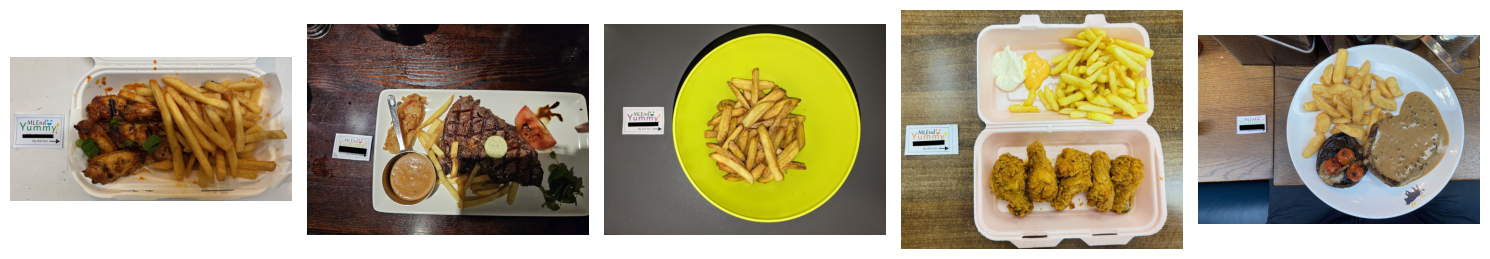

In [24]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

As expected, we can clearly notice the dishes containing rice and chips have been segregated accordingly.

###**b. Image Processing**

Since the images are of different sizes, let's resize the images. To keep the aspect ratio of image as it is, we will append black color on each side so that images are squared and then we will resize them to 200x200 pixels.

In [25]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(int((N-M)/2), int((N-M)/2))], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(int((M-N)/2), int((M-N)/2)),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

Let's now create arrays of images to be used in training and testing respectively.

In [26]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|1106\1106|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|288\288|
Done!


((1106, 200, 200, 3), (288, 200, 200, 3))

Let's now plot a few images after resizing:

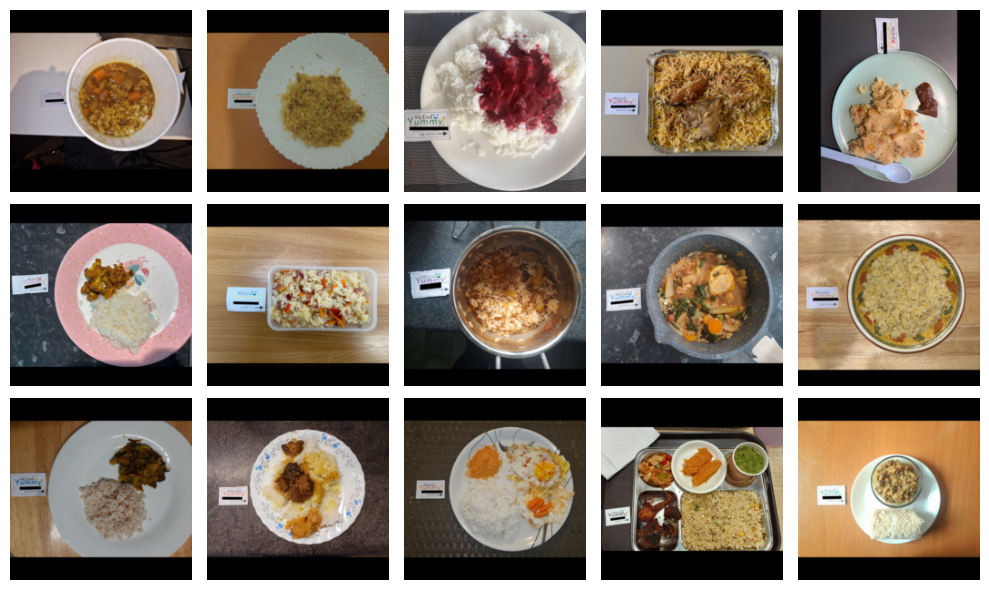

In [27]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

### **c. Feature Extraction:**

 Each photo is described by 3 x 200 x 200 = 120,000 values. Therefore, the predictor space has 120,000 dimensions. Let's reduce the dimensionality of the predictor space by feature extraction. Feature extraction is a common approach that allows us to reduce the dimensionality of our prediction space.

---
#### Followong are the feature extraction functions used in this project:

####**1. get_yellow_component(I, t1=27, t2=33):**

Input: Takes an RGB image I and optional threshold values t1 and t2.

Output: Returns the number of yellow pixels in the image that fall within the specified hue range defined by t1 and t2.


####**2. GMLC_features(I):**

Input: Takes an RGB image I.

Output: Computes and returns two texture features (f1 and f2) using the Gray-Level Co-occurrence Matrix (GLCM). Specifically, it calculates the dissimilarity and correlation features.


####**3. HOG_features(I):**

Input: Takes an RGB image I.

Output: Computes Histogram of Oriented Gradients (HOG) features from the grayscale version of the input image. Returns the computed HOG features.


####**4. color_histogram_features(I):**

Input: Takes an RGB image I.

Output: Computes and returns histograms for the red, green, and blue channels separately. Each histogram represents the distribution of pixel intensities in the corresponding color channel.

In [28]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

In [29]:
def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2

In [30]:
from skimage.feature import hog
from skimage import exposure

def HOG_features(I):
    I_gray = rgb2gray(I)
    features, hog_image = hog(I_gray, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True)
    return features

In [31]:
def color_histogram_features(I):
    hist_red, edges_red = np.histogram(I[:,:,0], bins=256, range=(0, 256))
    hist_green, edges_green = np.histogram(I[:,:,1], bins=256, range=(0, 256))
    hist_blue, edges_blue = np.histogram(I[:,:,2], bins=256, range=(0, 256))

    return hist_red, hist_green, hist_blue

Also, let's create a function to plot the confusion matrix of outcome.

In [32]:
def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

#**5 Modelling**


Using two machine learning models:

Linear SVM:

> SVMs are effective in high-dimensional spaces, making them suitable for image classification where each pixel can be considered a feature.

> They work well when the decision boundary is complex or nonlinear.

> SVMs are less prone to overfitting, especially in high-dimensional spaces.



Logistic Regression:


> Logistic Regression is computationally efficient and can be trained quickly.

> It is a simpler model compared to SVM, making it easier to interpret.


Out of these two, we will select the best ones based on the methodology.


#**6 Methodology**

The models are trained and evaluated using accuracy as the performance metric. The dataset is preprocessed to handle class imbalance, and feature extraction is performed using image processing techniques. The pipeline includes steps for data preprocessing, image processing, feature extraction, model training, and evaluation.

#**7 Dataset**

**Description:** The MLEnd Yummy Dataset is a collection of images featuring various dishes. In this step, the dataset of image description is loaded from a CSV file (MLEndYD_image_attributes_benchmark.csv), which contains information about each image, such as filename, dish name, ingredients, and benchmark labels. The dataset is indexed based on filenames for easy retrieval.

**Filtering for Rice or Chips:** To focus the machine learning model on distinguishing between rice and chips dishes, a filtering process is applied. Rows in the dataset are retained only if the 'Dish_name' or 'Ingredients' columns contain keywords indicative of rice or chips. This ensures that the dataset is tailored to the specific task at hand, enhancing the model's ability to learn relevant features.

```
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
filtered_df = MLENDYD_df[MLENDYD_df['Dish_name'].str.contains('(rice|chips|fries|wedges)', case=False, na=False) | MLENDYD_df['Ingredients'].str.contains('(rice|chips)', case=False, na=False)]
```


This step ensures that the subsequent training and testing sets are focused on relevant image samples, creating a more targeted dataset for the binary classification task. The filtering process is crucial for training a model that can effectively distinguish between images of dishes containing rice and those containing chips. By considering both the dish name and ingredients, the model gains exposure to various textual cues that might indicate the presence of rice or chips in the image.

Now that we have the image dataset splitted to X_train and Y_train, let's extract features and create numeric Training and Test sets and use it for our model.

Let us first extract the three features from each image and create the transform sets X_train_f and X_test_f:

In [33]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

After formatting both X_train_f and X_test_f as numpy arrays, we can check their respective shapes:

In [34]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((1106, 3), (288, 3))

As we can see here, the dimensionality of our dataset has been reduced from 120000D to 3D.

Let's implement a normalisation stage to ensure that the 3 attributes in the new prediction space take on a similar range of values. We will implement standardisation.

In [35]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

###**d. Model Training:**

Let's implement SVM and train our model.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

model = LinearSVC(C=1)
model.fit(X_train_fn, Y_train)

LinearSVC(C=1)

In [37]:
ytp_yg_svm = model.predict(X_train_fn)
ysp_yg_svm = model.predict(X_test_fn)

train_accuracy = np.mean(ytp_yg_svm==Y_train)
test_accuracy  = np.mean(ysp_yg_svm==Y_test)

print('Training Accuracy:',train_accuracy)
print('Test  Accuracy:',test_accuracy)

Training Accuracy: 0.5587703435804702
Test  Accuracy: 0.5520833333333334


Let's implement another model (Logistic Regression) and find if there is any improvement.

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_fn,Y_train)
acc_log = round(logreg.score(X_train_fn, Y_train) * 100, 2)
acc_log

56.06

In [39]:
ytp_yg_lr = logreg.predict(X_train_fn)
ysp_yg_lr = logreg.predict(X_test_fn)

print('Training Accuracy:', np.mean(ytp_yg_lr==Y_train))
print('Test  Accuracy:', np.mean(ysp_yg_lr==Y_test))

Training Accuracy: 0.5605786618444847
Test  Accuracy: 0.5486111111111112


In [52]:
model = RandomForestClassifier(n_estimators=5, criterion='log_loss', max_depth=5, class_weight='balanced')
model.fit(X_train_fn, Y_train)

ytp_yg_rf = logreg.predict(X_train_fn)
ysp_yg_rf = logreg.predict(X_test_fn)

print('Training Accuracy:', np.mean(ytp_yg_lr==Y_train))
print('Test  Accuracy:', np.mean(ysp_yg_lr==Y_test))

Training Accuracy: 0.5605786618444847
Test  Accuracy: 0.5486111111111112


The accuracies are nearly same. Although, SVM model is performing slightly better.

Let's try to improve the accuracy by considering one more feature extraction Histogram of Oriented Gradients (HOG). HOG is a popular feature descriptor for object detection. It captures the local intensity gradients in different directions.

Let's repeat the process and create a new training and test image sets and observe the accuracies. Note that we will extract 4 HOG features which will make the Dataset to 7D.

In [40]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Extracting features for each image in the training set
X_train_f = []
for I in X_train:
    f1 = HOG_features(I)
    f2, f3 = GMLC_features(I)
    f4 = get_yellow_component(I)

    # Concatenate features along one axis (axis=0 in this case)
    features = np.concatenate([f1[:4], [f2, f3, f4]])

    X_train_f.append(features)

# Extracting features for each image in the test set
X_test_f = []
for I in X_test:
    f1 = HOG_features(I)
    f2, f3 = GMLC_features(I)
    f4 = get_yellow_component(I)

    # Concatenate features along one axis (axis=0 in this case)
    features = np.concatenate([f1[:4], [f2, f3, f4]])

    X_test_f.append(features)

# Converting the lists to numpy arrays
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)

# Computing mean and standard deviation using NumPy
MEAN = np.mean(X_train_f, axis=0)
SD = np.std(X_train_f, axis=0)

# Applying StandardScaler
X_train_fn = (X_train_f - MEAN) / SD
X_test_fn = (X_test_f - MEAN) / SD


In [41]:
X_train_fn.shape

(1106, 7)

The shape identifies that the dataset is an 7D. Note that we have selected 4 features from HOG because more than 4 features shows underfitting or overfitting, and for lesser features accuracy is not that good.

Let's get the accuracies both by SVM and Logistic Regression Model for this combination.

In [42]:
print("Using HOG feature along with GMLC and Yellow Component\n")

model = LinearSVC(C=1)
model.fit(X_train_fn, Y_train)

ytp_ygh_svm = model.predict(X_train_fn)
ysp_ygh_svm = model.predict(X_test_fn)

train_accuracy = np.mean(ytp_ygh_svm==Y_train)
test_accuracy  = np.mean(ysp_ygh_svm==Y_test)

print('SVM Model:')
print('Training Accuracy: ',train_accuracy)
print('Test  Accuracy: ',test_accuracy)

logreg = LogisticRegression()
logreg.fit(X_train_fn,Y_train)
acc_log = round(logreg.score(X_train_fn, Y_train) * 100, 2)
acc_log

ytp_ygh_lr = logreg.predict(X_train_fn)
ysp_ygh_lr = logreg.predict(X_test_fn)

print('------------------------')
print('Logistic Regression Model:')
print('Training Accuracy', np.mean(ytp_ygh_lr==Y_train))
print('Test  Accuracy', np.mean(ysp_ygh_lr==Y_test))

Using HOG feature along with GMLC and Yellow Component

SVM Model:
Training Accuracy:  0.5605786618444847
Test  Accuracy:  0.5555555555555556
------------------------
Logistic Regression Model:
Training Accuracy 0.5623869801084991
Test  Accuracy 0.5590277777777778


As we can see adding 4 more features (HOG features), the accuracy did not out perform the previous ones but its slightly better.

Let's use another feature color histograms to see if this improves the result. We have created a function the extracts histograms of pixel values in different color channels.

Let's train the model by extracting just this feature.

In [43]:
X_train_f = []
for I in X_train:
    f1,f2,f3 = color_histogram_features(I)

    f1 = np.ravel(f1)
    f2 = np.ravel(f2)
    f3 = np.ravel(f3)

    X_train_f.append(np.concatenate([f1, f2, f3]))

X_test_f = []
for I in X_test:
    f1,f2,f3 = color_histogram_features(I)

    f1 = np.ravel(f1)
    f2 = np.ravel(f2)
    f3 = np.ravel(f3)

    X_test_f.append(np.concatenate([f1, f2, f3]))

scaler = StandardScaler()

X_train_fn = np.vstack(X_train_f)
X_test_fn = np.vstack(X_test_f)

X_train_fn = scaler.fit_transform(X_train_fn)
X_test_fn = scaler.transform(X_test_fn)

In [44]:
X_train_fn.shape

(1106, 768)

High dimensional dataset. it could probably lead to underfitting or overfitting. Let's observe the outcome.

In [45]:
print("Using Color Histogram Feature\n")

model = LinearSVC(C=1)
model.fit(X_train_fn, Y_train)

ytp_ch_svm = model.predict(X_train_fn)
ysp_ch_svm = model.predict(X_test_fn)

train_accuracy = np.mean(ytp_ch_svm==Y_train)
test_accuracy  = np.mean(ysp_ch_svm==Y_test)

print('SVM Model:')
print('Training Accuracy: ',train_accuracy)
print('Test  Accuracy: ',test_accuracy)

logreg = LogisticRegression()
logreg.fit(X_train_fn,Y_train)
acc_log = round(logreg.score(X_train_fn, Y_train) * 100, 2)

ytp_ch_lr = logreg.predict(X_train_fn)
ysp_ch_lr = logreg.predict(X_test_fn)

print('------------------------')
print('Logistic Regression Model:')
print('Training Accuracy', np.mean(ytp_ch_lr==Y_train))
print('Test  Accuracy', np.mean(ysp_ch_lr==Y_test))

Using Color Histogram Feature

SVM Model:
Training Accuracy:  0.5054249547920434
Test  Accuracy:  0.8611111111111112
------------------------
Logistic Regression Model:
Training Accuracy 0.5045207956600362
Test  Accuracy 0.8611111111111112


Underfitting!

Let's try once more by extracting multiple features this time, 1 from Yellow Component and 3 types of multiple feature from Color Histograms.

In [46]:
X_train_f = []
for I in X_train:
    f1,f2,f3 = color_histogram_features(I)
    f4 = get_yellow_component(I)

    f1 = np.ravel(f1)
    f2 = np.ravel(f2)
    f3 = np.ravel(f3)
    f4 = np.ravel(f4)

    X_train_f.append(np.concatenate([f1, f2, f3, f4]))

X_test_f = []
for I in X_test:
    f1,f2,f3 = color_histogram_features(I)
    f4 = get_yellow_component(I)

    f1 = np.ravel(f1)
    f2 = np.ravel(f2)
    f3 = np.ravel(f3)
    f4 = np.ravel(f4)

    X_test_f.append(np.concatenate([f1, f2, f3, f4]))

X_train_fn = np.vstack(X_train_f)
X_test_fn = np.vstack(X_test_f)

X_train_fn = scaler.fit_transform(X_train_fn)
X_test_fn = scaler.transform(X_test_fn)

In [47]:
X_train_fn.shape

(1106, 769)

In [48]:
print("Using Color Histogram feature along with Yellow Component\n")

model = LinearSVC(C=1)
model.fit(X_train_fn, Y_train)

ytp_yhc_svm = model.predict(X_train_fn)
ysp_yhc_svm = model.predict(X_test_fn)

train_accuracy = np.mean(ytp_yhc_svm==Y_train)
test_accuracy  = np.mean(ysp_yhc_svm==Y_test)

print('SVM Model:')
print('Training Accuracy: ',train_accuracy)
print('Test  Accuracy: ',test_accuracy)

logreg = LogisticRegression()
logreg.fit(X_train_fn,Y_train)
acc_log = round(logreg.score(X_train_fn, Y_train) * 100, 2)
acc_log

ytp_yhc_lr = logreg.predict(X_train_fn)
ysp_yhc_lr = logreg.predict(X_test_fn)

print('------------------------')
print('Logistic Regression Model:')
print('Training Accuracy', np.mean(ytp_yhc_lr==Y_train))
print('Test  Accuracy', np.mean(ysp_yhc_lr==Y_test))

Using Color Histogram feature along with Yellow Component

SVM Model:
Training Accuracy:  0.46473779385171793
Test  Accuracy:  0.53125
------------------------
Logistic Regression Model:
Training Accuracy 0.4602169981916817
Test  Accuracy 0.5590277777777778


The above result slightly underfits.

The result obtained by extracting HOG feature along with GMLC and Yellow Component in Logistic Regression Model performs the best.

#**8 Results**

The optimal model configuration for accurately distinguishing between dishes with rice and chips was identified through comprehensive experimentation. The winning combination comprises seven distinctive features: one derived from the Yellow Component, two from Gray Level Co-occurrence Matrix (GMLC) analysis and four from Histogram of Colors (HOG). This feature set, coupled with the application of a Logistic Regression model, yielded the most promising outcomes.

Selected Model and Features

Model: Logistic Regression

Features:

> 1 feature from Yellow Component

> 2 features from GMLC analysis

> 4 features from HOG

Performance Metrics

> Training Accuracy: 56.23%

> Test  Accuracy: 55.90%



Let's plot the confusion matrix and observe the obtained result.

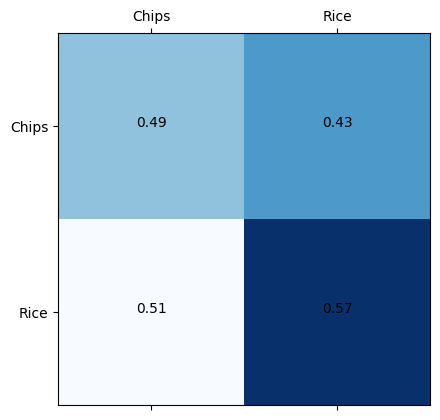

In [49]:
Ac = np.mean(ysp_ygh_lr[Y_test==0]==0)
Ar = np.mean(ysp_ygh_lr[Y_test==1]==1)

Mc = np.mean(ysp_ygh_lr[Y_test==0]==1)
Mr = np.mean(ysp_ygh_lr[Y_test==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

As per confusion matrix, the model performs better for rice than for chips. This could possibly be due to less image of chips in test set.

#**9 Conclusion**

In conclusion, this project aimed to develop a machine learning pipeline for classifying images of dishes containing either rice or chips. The MLEnd Yummy Dataset was utilized, and the pipeline included data download, preprocessing, image processing, feature extraction, model training, and evaluation stages.

The dataset was filtered to include only images with rice or chips, addressing class imbalance by oversampling. Three image features, namely the yellow component, color histograms, and GMLC features, were extracted. The machine learning pipeline employed two models, Linear SVM and Logistic Regression.

The models were trained and evaluated on a balanced dataset, resulting in reasonable accuracy. However, further experimentation with additional features, such as Histogram of Oriented Gradients (HOG), did not significantly improve performance. The addition of color histograms alone resulted in underfitting.